# Практическое задание

## Урок 7. Интерпретация прогнозов модели (SHAP): объясняем поведение модели на отдельных наблюдениях

- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета 
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

продолжим работу с датасетом по заболеваниям почек

In [1]:
# импортируем необходимые библиотеки и модули

import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

import itertools

import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

ссылка на датасет: https://www.kaggle.com/datasets/imnoob/kidney-disease

In [2]:
data = pd.read_csv('kidney_disease.csv')
data.head(3)

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.02,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.02,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.01,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd


In [3]:
print(data.shape)

(400, 26)


In [4]:
# таргет

data.iloc[:, -1].value_counts()

ckd       248
notckd    150
ckd\t       2
Name: classification, dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              400 non-null    int64  
 1   age             391 non-null    float64
 2   bp              388 non-null    float64
 3   sg              353 non-null    float64
 4   al              354 non-null    float64
 5   su              351 non-null    float64
 6   rbc             248 non-null    object 
 7   pc              335 non-null    object 
 8   pcc             396 non-null    object 
 9   ba              396 non-null    object 
 10  bgr             356 non-null    float64
 11  bu              381 non-null    float64
 12  sc              383 non-null    float64
 13  sod             313 non-null    float64
 14  pot             312 non-null    float64
 15  hemo            348 non-null    float64
 16  pcv             330 non-null    object 
 17  wc              295 non-null    obj

# EDA (exploratory data analysis)

столбец id не является признаком, удалим его

In [6]:
data.drop (columns=data.columns[0], axis= 1 , inplace= True )
data.head(3)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.02,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.02,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.01,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             391 non-null    float64
 1   bp              388 non-null    float64
 2   sg              353 non-null    float64
 3   al              354 non-null    float64
 4   su              351 non-null    float64
 5   rbc             248 non-null    object 
 6   pc              335 non-null    object 
 7   pcc             396 non-null    object 
 8   ba              396 non-null    object 
 9   bgr             356 non-null    float64
 10  bu              381 non-null    float64
 11  sc              383 non-null    float64
 12  sod             313 non-null    float64
 13  pot             312 non-null    float64
 14  hemo            348 non-null    float64
 15  pcv             330 non-null    object 
 16  wc              295 non-null    object 
 17  rc              270 non-null    obj

посмотрим какие типы данных у признаков

In [8]:
data_cats = data.select_dtypes(include='object').columns.tolist()
data_num = data.select_dtypes(include='float64').columns.tolist()

print(f'категориальные признаки - {data_cats}, количество - {len(data_cats)}')
print(f'непрерывные признаки - {data_num}, количество - {len(data_num)}')

категориальные признаки - ['rbc', 'pc', 'pcc', 'ba', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'classification'], количество - 14
непрерывные признаки - ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo'], количество - 11


Вывод: категориальных признаков 13, в том числе 1 "classification" - таргет; непрерывных - 11 

категориальные признаки

In [9]:
for data_cat in data_cats:
    dc_name = data[data_cat].unique()
    len_dc = len(data[data_cat].unique())
    print(f'признак - {data_cat}, уникальные значения - {dc_name}, количество уникальных значений - {len_dc}')

признак - rbc, уникальные значения - [nan 'normal' 'abnormal'], количество уникальных значений - 3
признак - pc, уникальные значения - ['normal' 'abnormal' nan], количество уникальных значений - 3
признак - pcc, уникальные значения - ['notpresent' 'present' nan], количество уникальных значений - 3
признак - ba, уникальные значения - ['notpresent' 'present' nan], количество уникальных значений - 3
признак - pcv, уникальные значения - ['44' '38' '31' '32' '35' '39' '36' '33' '29' '28' nan '16' '24' '37' '30'
 '34' '40' '45' '27' '48' '\t?' '52' '14' '22' '18' '42' '17' '46' '23'
 '19' '25' '41' '26' '15' '21' '43' '20' '\t43' '47' '9' '49' '50' '53'
 '51' '54'], количество уникальных значений - 45
признак - wc, уникальные значения - ['7800' '6000' '7500' '6700' '7300' nan '6900' '9600' '12100' '4500'
 '12200' '11000' '3800' '11400' '5300' '9200' '6200' '8300' '8400' '10300'
 '9800' '9100' '7900' '6400' '8600' '18900' '21600' '4300' '8500' '11300'
 '7200' '7700' '14600' '6300' '\t6200' '7

признаки 'pcv', 'wc', 'rc' - являются непрерывным, изменим их тип данных с object на int 

In [10]:
for el in data['pcv']:
    try:
        el = int(el)
        if (isinstance(el, (int, float))):
            pass
        else:
            el = 0
#             print(el)
#             pass
    except:
        el = 0
#         print(el)

list_convert_feats = ['pcv', 'wc', 'rc']
    
for feat in list_convert_feats:
    data[feat] = pd.to_numeric(data[feat], errors='coerce')
    data = data.dropna(subset=[feat])
    for el in list_convert_feats[:2]:                                 
        data[feat].astype('int')
    for el in list_convert_feats[2]:                                 
        data[feat].astype('int')    

обработка выбросов

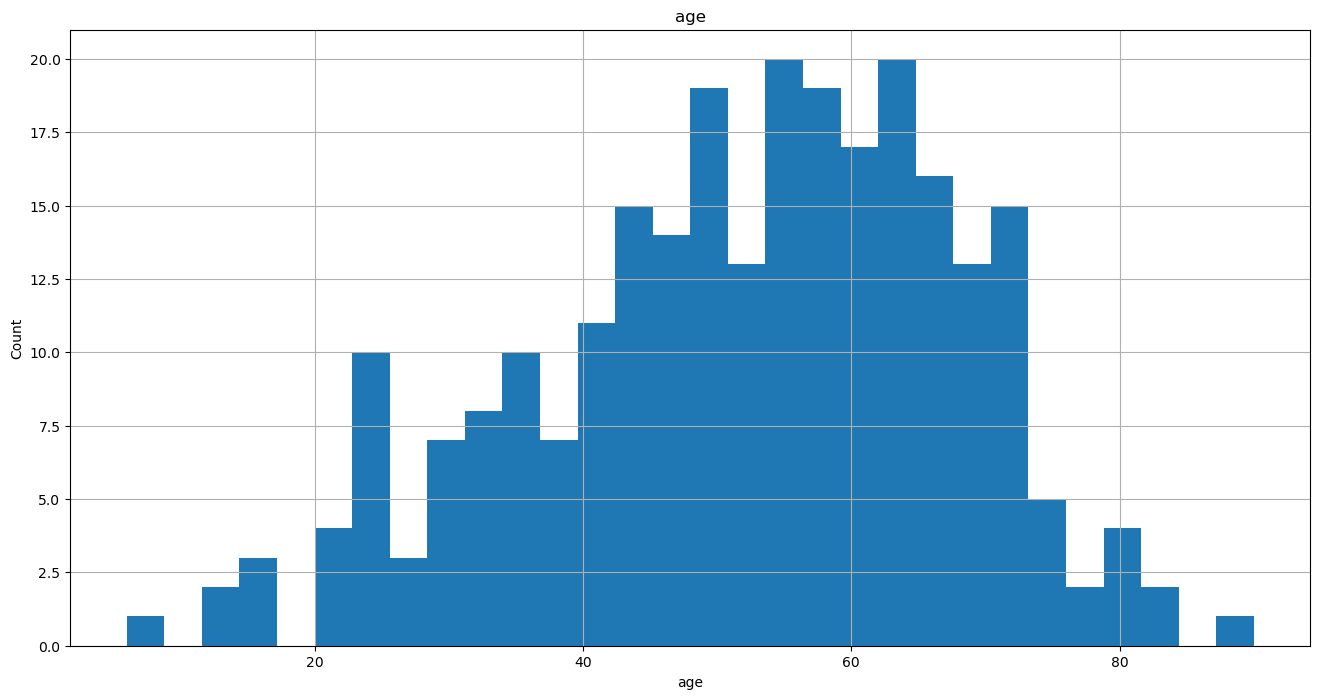

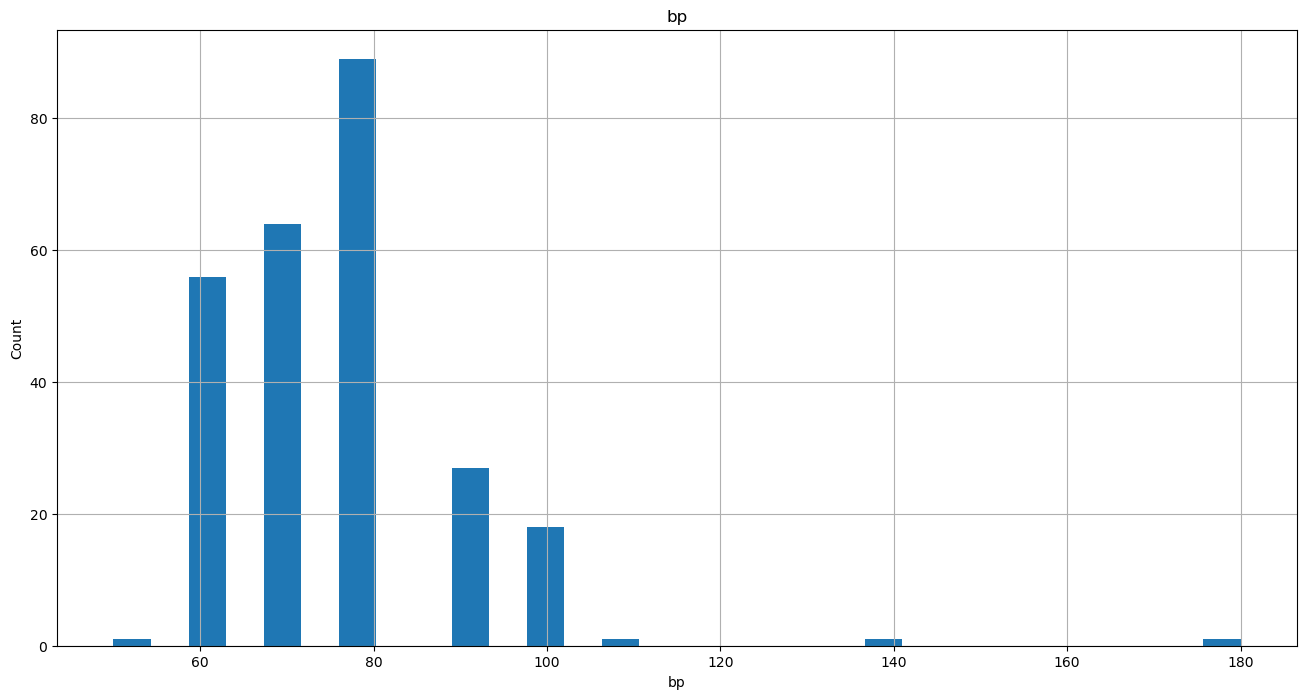

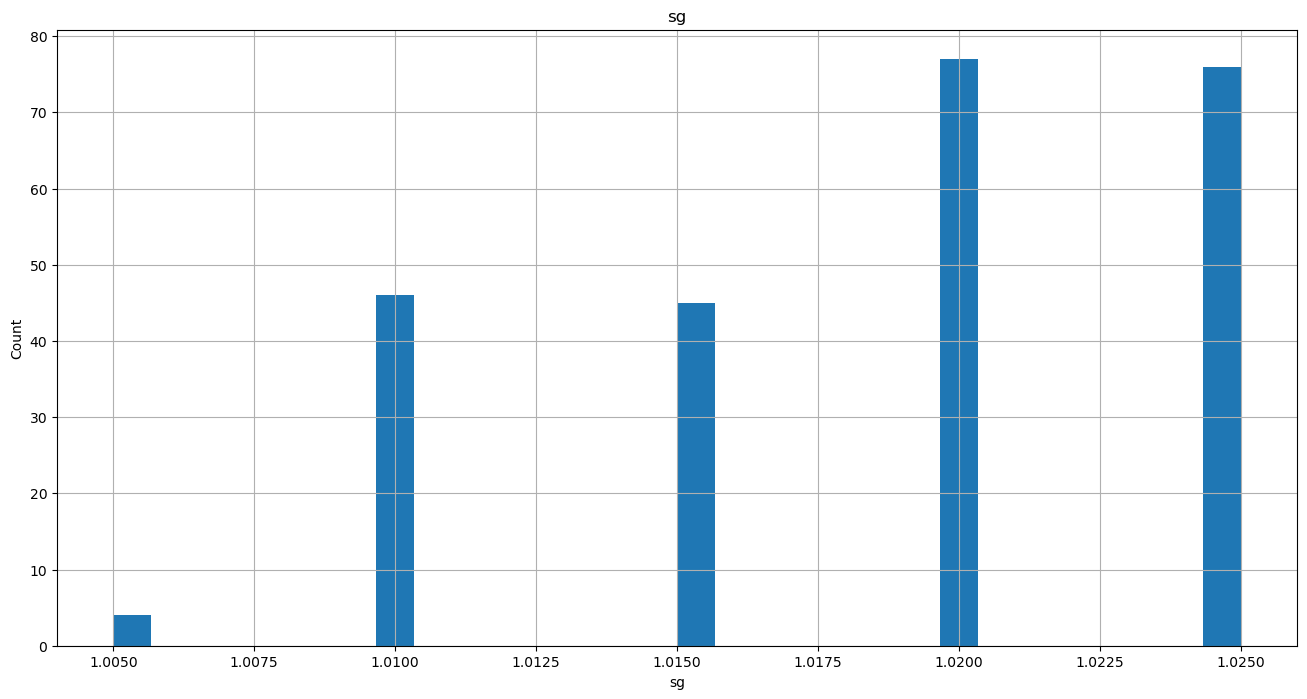

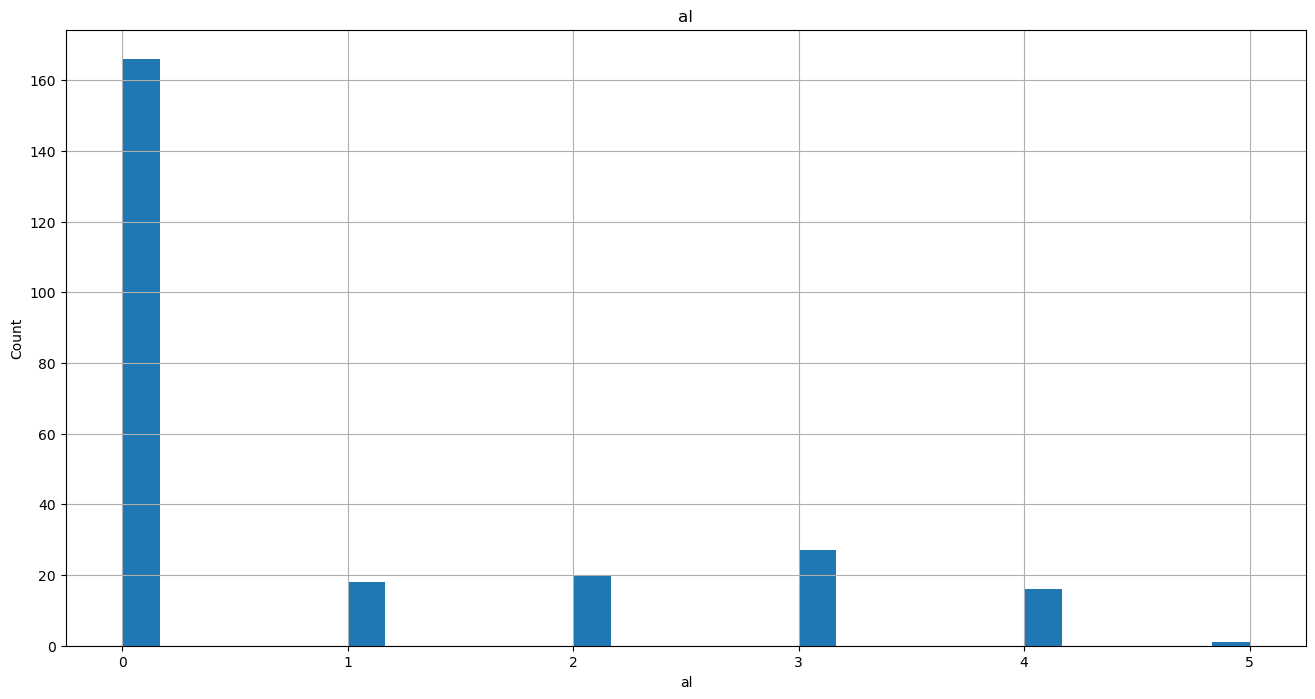

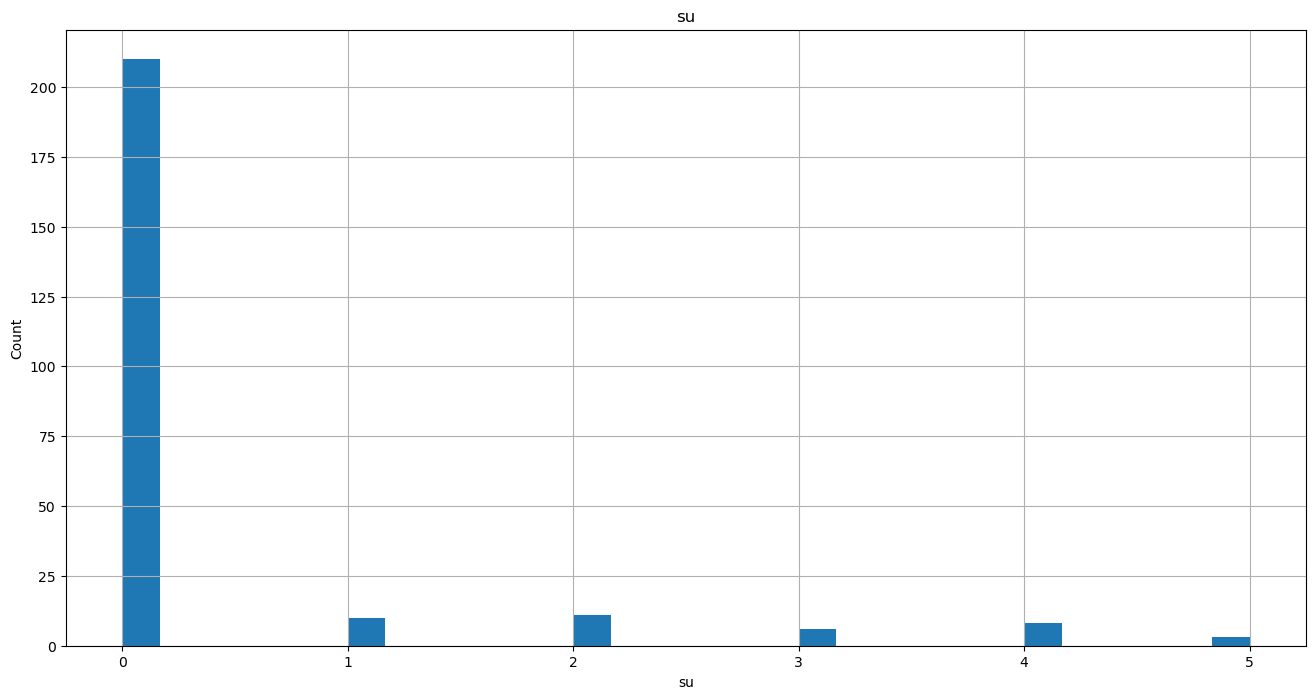

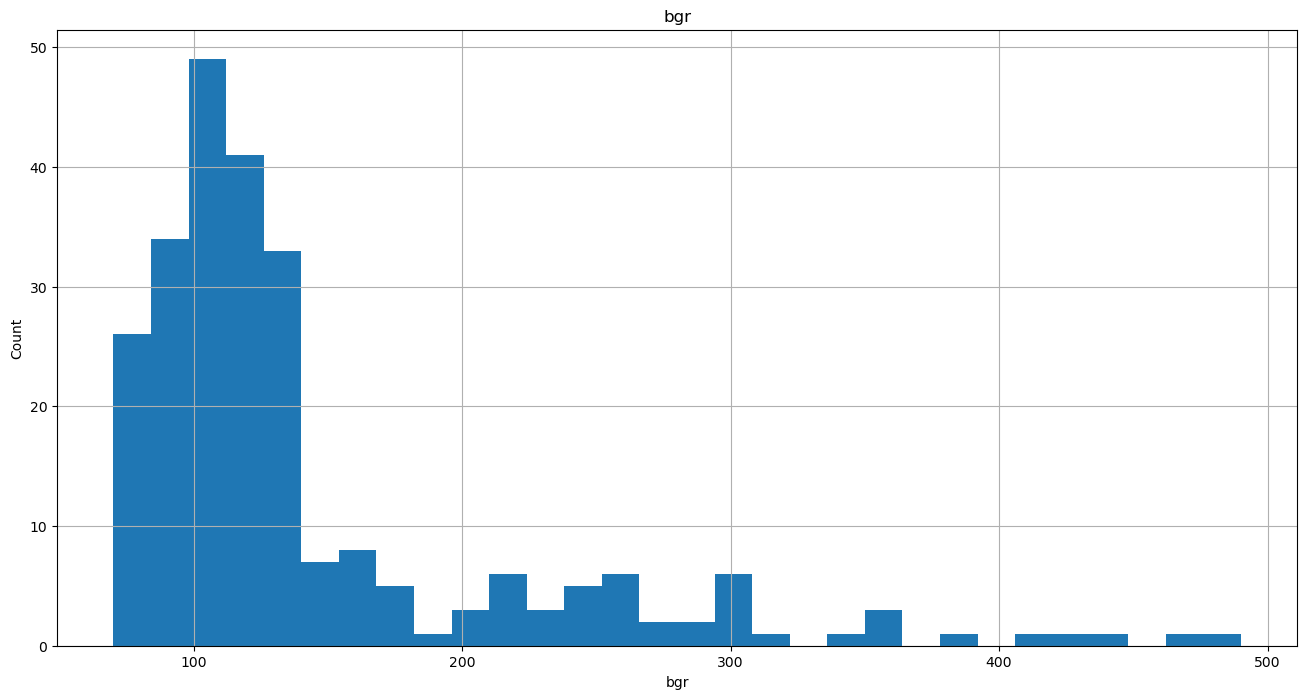

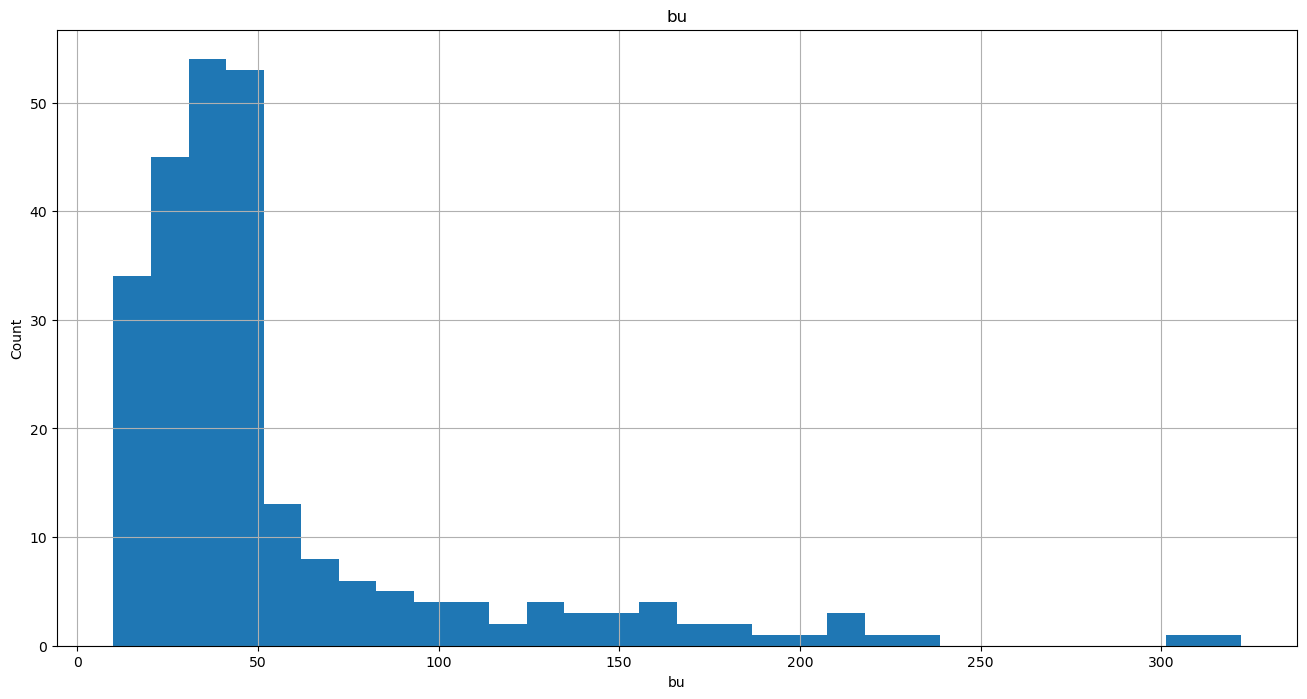

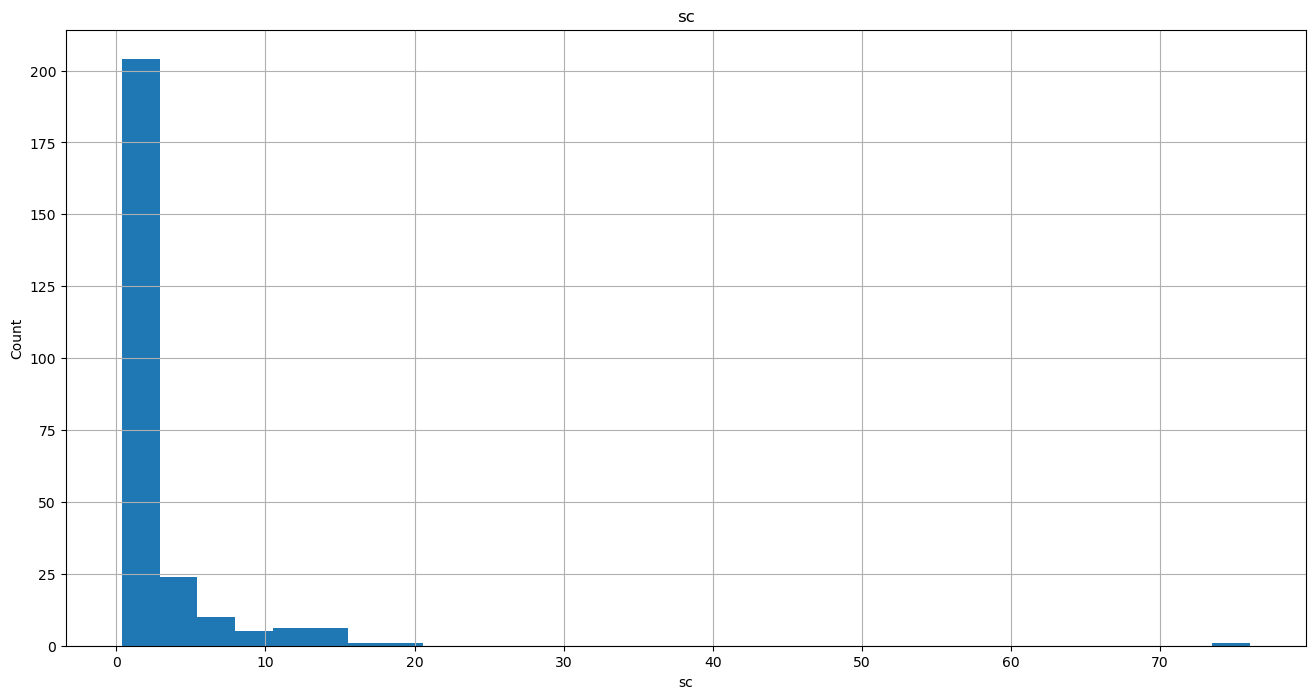

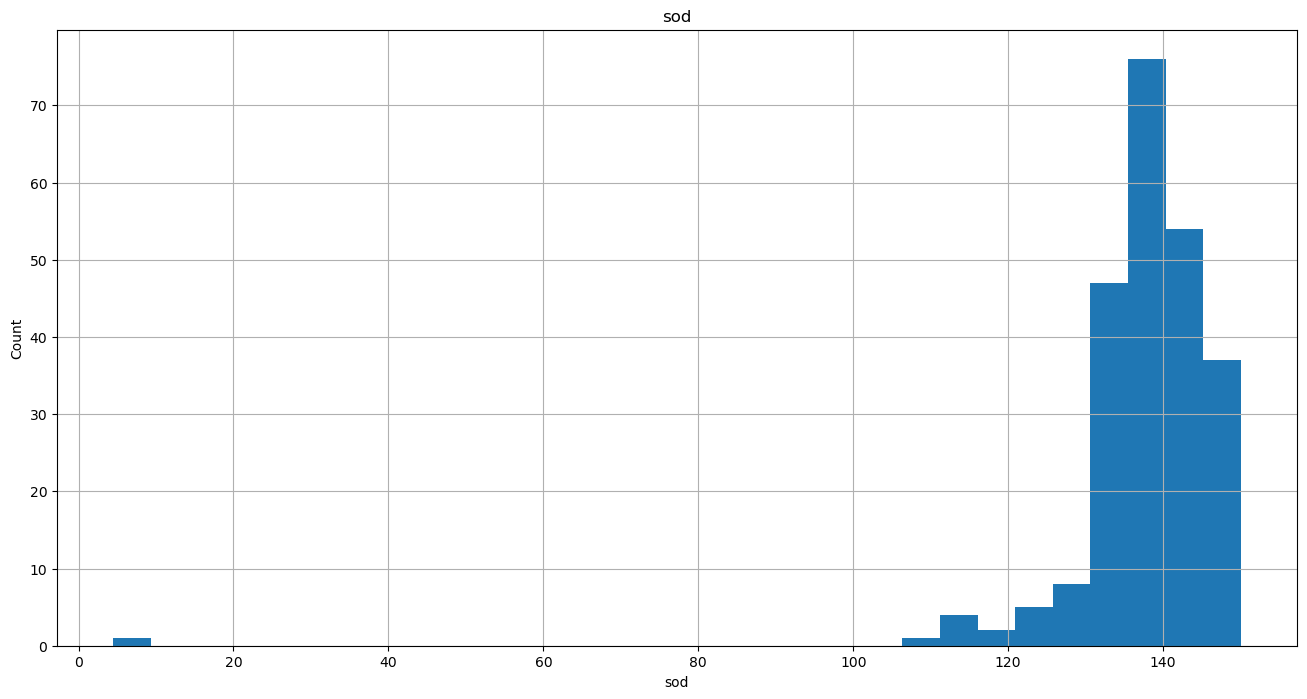

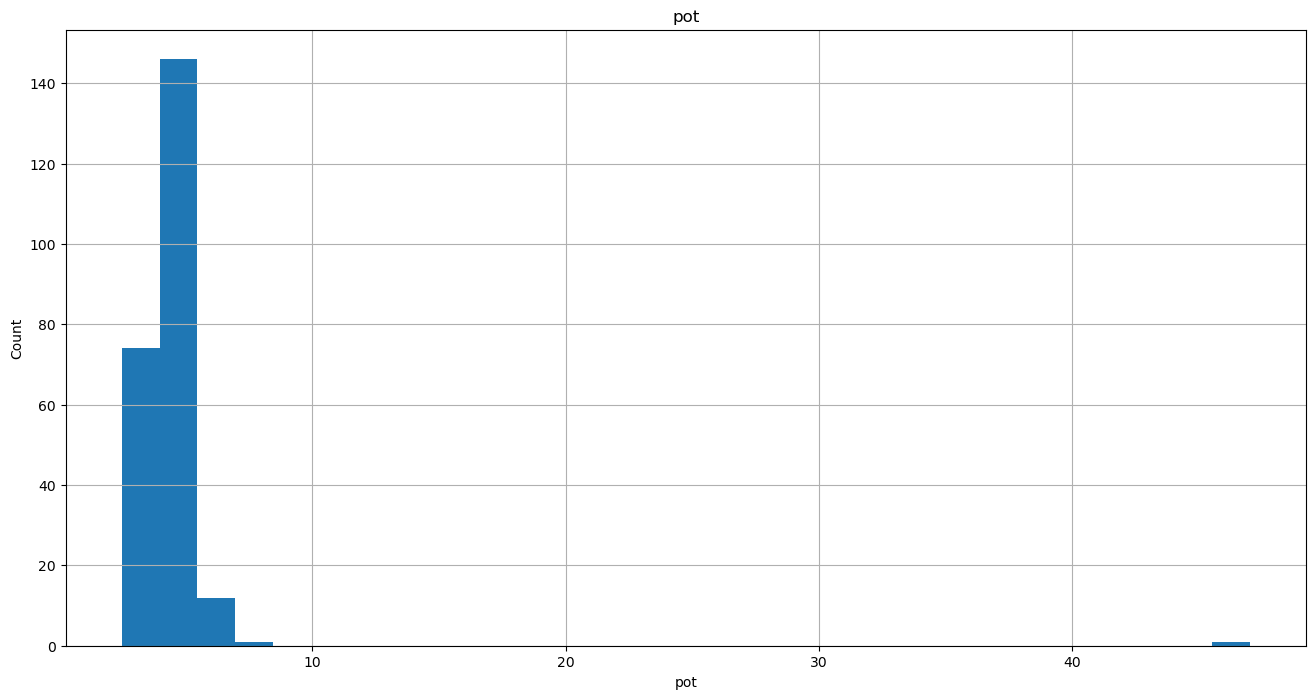

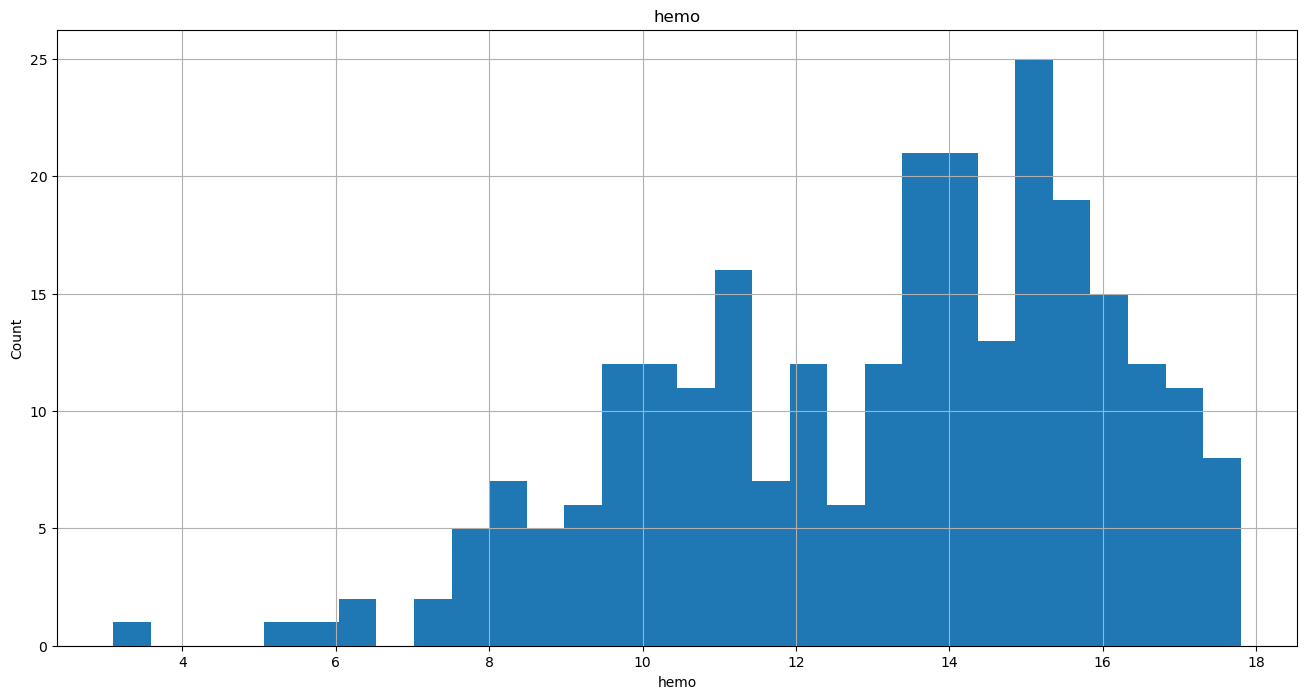

In [11]:
for num in data_num: 
    plt.figure(figsize = (16, 8))
    data[num].hist(bins=30)
    plt.ylabel('Count')
    plt.xlabel(num)
    plt.title(num)
    plt.show()


In [12]:
for num in data_num:
    print(f'{data[num].describe()}\n')

count    261.000000
mean      51.919540
std       15.669828
min        6.000000
25%       42.000000
50%       55.000000
75%       63.000000
max       90.000000
Name: age, dtype: float64

count    258.000000
mean      76.240310
std       14.011266
min       50.000000
25%       70.000000
50%       80.000000
75%       80.000000
max      180.000000
Name: bp, dtype: float64

count    248.000000
mean       1.018528
std        0.005687
min        1.005000
25%        1.015000
50%        1.020000
75%        1.025000
max        1.025000
Name: sg, dtype: float64

count    248.000000
mean       0.838710
std        1.346082
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max        5.000000
Name: al, dtype: float64

count    248.000000
mean       0.391129
std        1.051431
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        5.000000
Name: su, dtype: float64

count    248.000000
mean     142.697581
std       76.656083
min      

### AGE

In [13]:
data['age'].describe()

count    261.000000
mean      51.919540
std       15.669828
min        6.000000
25%       42.000000
50%       55.000000
75%       63.000000
max       90.000000
Name: age, dtype: float64

In [14]:
data.loc[((data['age'] < 18))]

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
62,15.0,60.0,1.020,3.0,0.0,NaN,normal,notpresent,notpresent,86.0,...,33.0,7700.0,3.8,yes,yes,no,good,no,no,ckd
164,14.0,NaN,1.015,0.0,0.0,NaN,NaN,notpresent,notpresent,192.0,...,40.0,9500.0,5.4,no,yes,no,poor,yes,no,ckd
190,6.0,60.0,1.010,4.0,0.0,abnormal,abnormal,notpresent,present,94.0,...,30.0,16700.0,4.8,no,no,no,poor,no,no,ckd
387,15.0,80.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,93.0,...,50.0,6200.0,5.2,no,no,no,good,no,no,notckd
397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,100.0,...,49.0,6600.0,5.4,no,no,no,good,no,no,notckd
398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,114.0,...,51.0,7200.0,5.9,no,no,no,good,no,no,notckd


In [15]:
data = data[(data['age'] > 18) & (data['age'] < 85)]

### BU

In [16]:
data['bu'].describe()

count    245.000000
mean      56.375510
std       50.417903
min       10.000000
25%       27.000000
50%       40.000000
75%       55.000000
max      322.000000
Name: bu, dtype: float64

In [17]:
data = data[data['bu'] < 250]

### SC

In [18]:
data['sc'].describe()

count    243.000000
mean       2.651235
std        5.610949
min        0.400000
25%        0.800000
50%        1.200000
75%        2.400000
max       76.000000
Name: sc, dtype: float64

In [19]:
data = data[data['sc'] < 30]

### SOD

In [20]:
data['sod'].describe()

count    216.000000
mean     138.819444
std        7.122176
min      111.000000
25%      135.000000
50%      139.000000
75%      143.000000
max      150.000000
Name: sod, dtype: float64

In [21]:
data = data[data['sod'] > 100]

### POT

In [22]:
data['pot'].describe()

count    216.000000
mean       4.572685
std        2.994203
min        2.500000
25%        3.800000
50%        4.500000
75%        4.900000
max       47.000000
Name: pot, dtype: float64

In [23]:
data = data[data['pot'] < 10]

### HEMO 

In [24]:
data['hemo'].describe()

count    214.000000
mean      13.229439
std        2.866992
min        5.500000
25%       11.125000
50%       13.850000
75%       15.400000
max       17.800000
Name: hemo, dtype: float64

In [25]:
data = data[data['hemo'] > 5]

In [26]:
for num in data_num:
    print(f'{data[num].describe()}\n')

count    214.000000
mean      52.504673
std       14.378109
min       20.000000
25%       43.000000
50%       54.500000
75%       63.000000
max       83.000000
Name: age, dtype: float64

count    211.000000
mean      75.734597
std       14.369468
min       50.000000
25%       70.000000
50%       80.000000
75%       80.000000
max      180.000000
Name: bp, dtype: float64

count    201.000000
mean       1.019080
std        0.005592
min        1.005000
25%        1.015000
50%        1.020000
75%        1.025000
max        1.025000
Name: sg, dtype: float64

count    202.000000
mean       0.787129
std        1.326812
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        4.000000
Name: al, dtype: float64

count    202.000000
mean       0.381188
std        1.021287
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        5.000000
Name: su, dtype: float64

count    210.000000
mean     139.057143
std       76.625021
min      

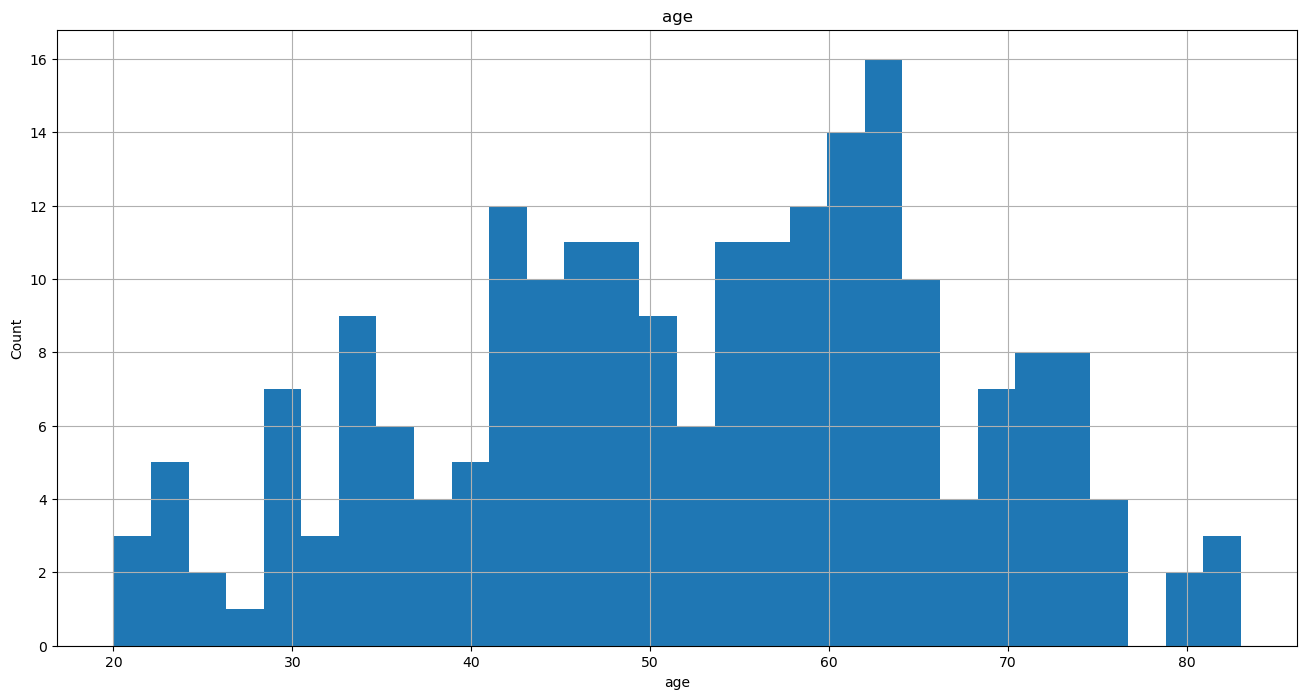

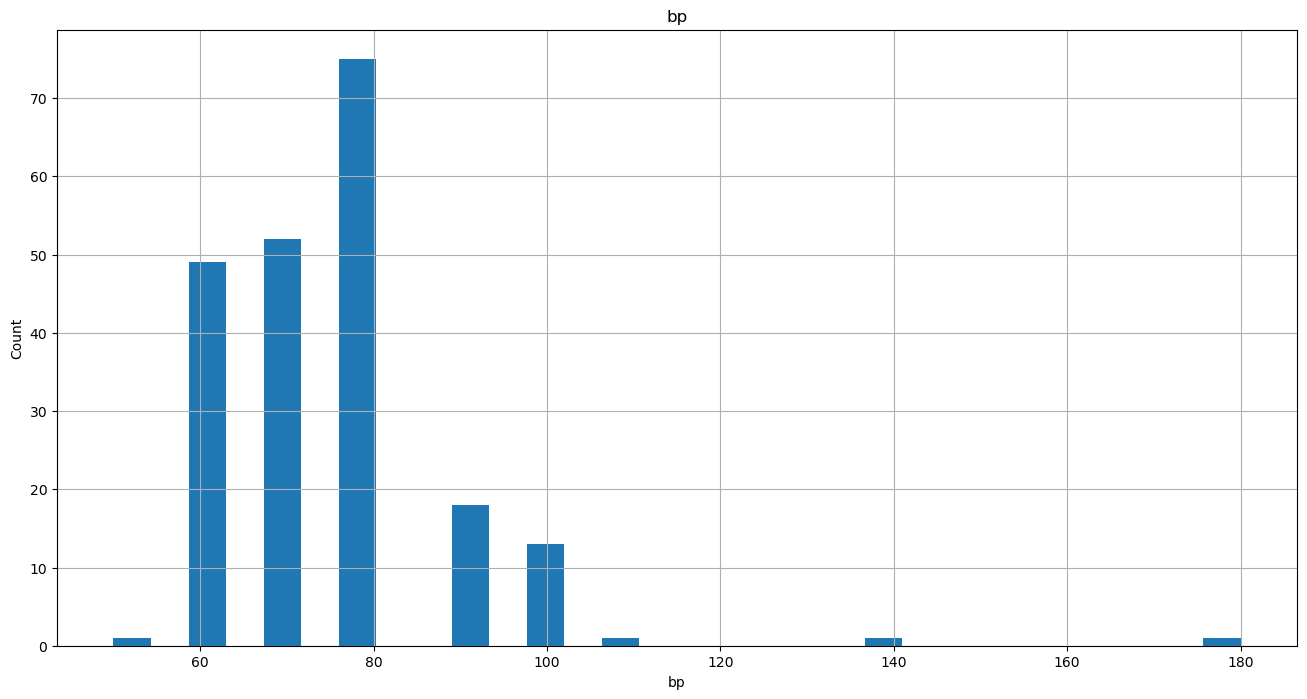

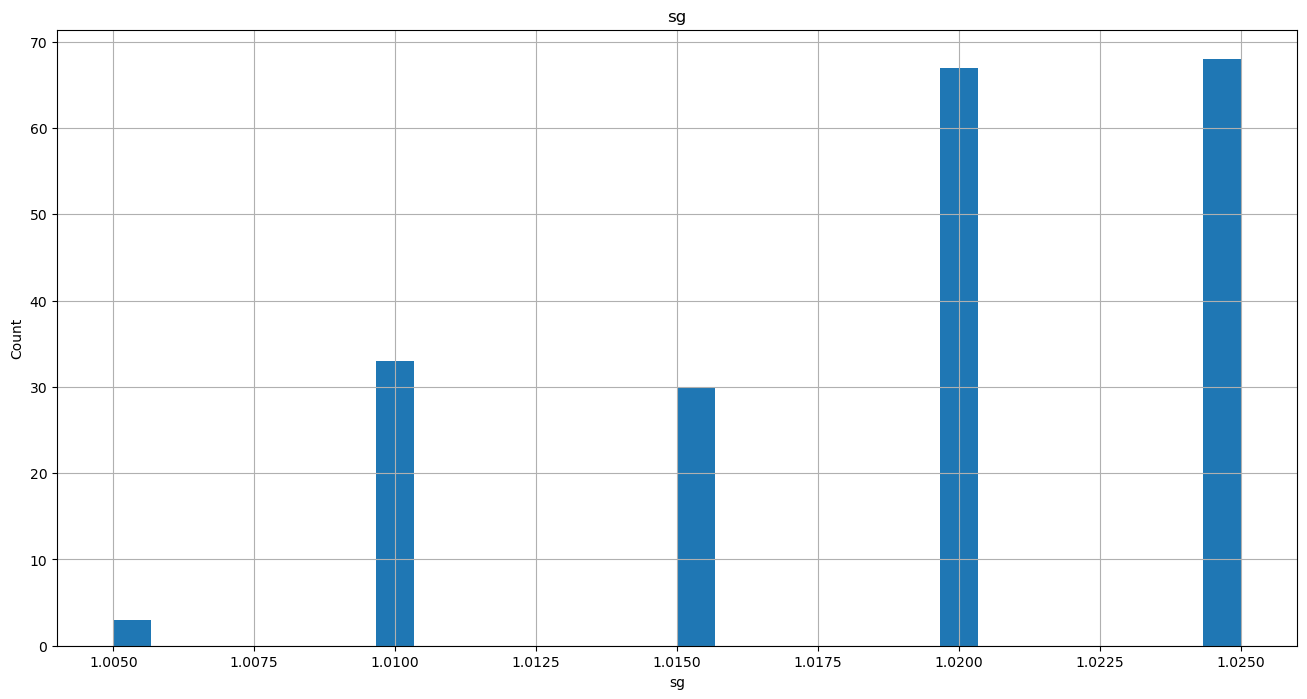

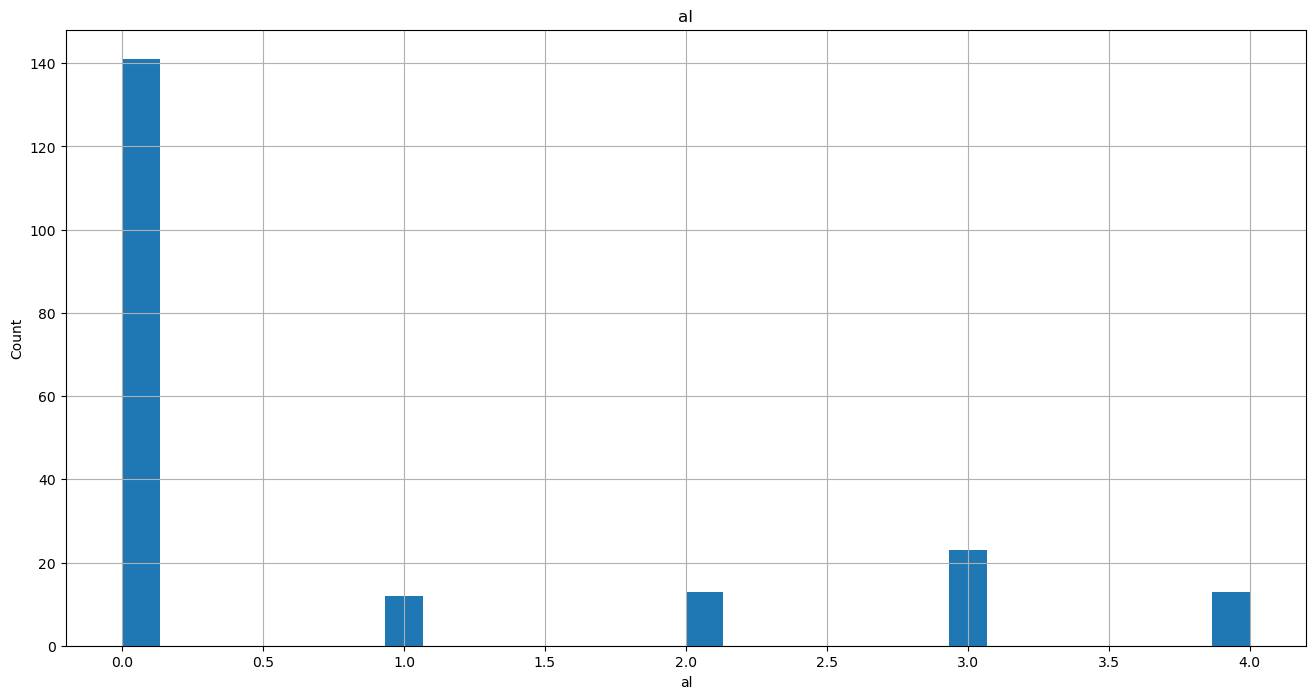

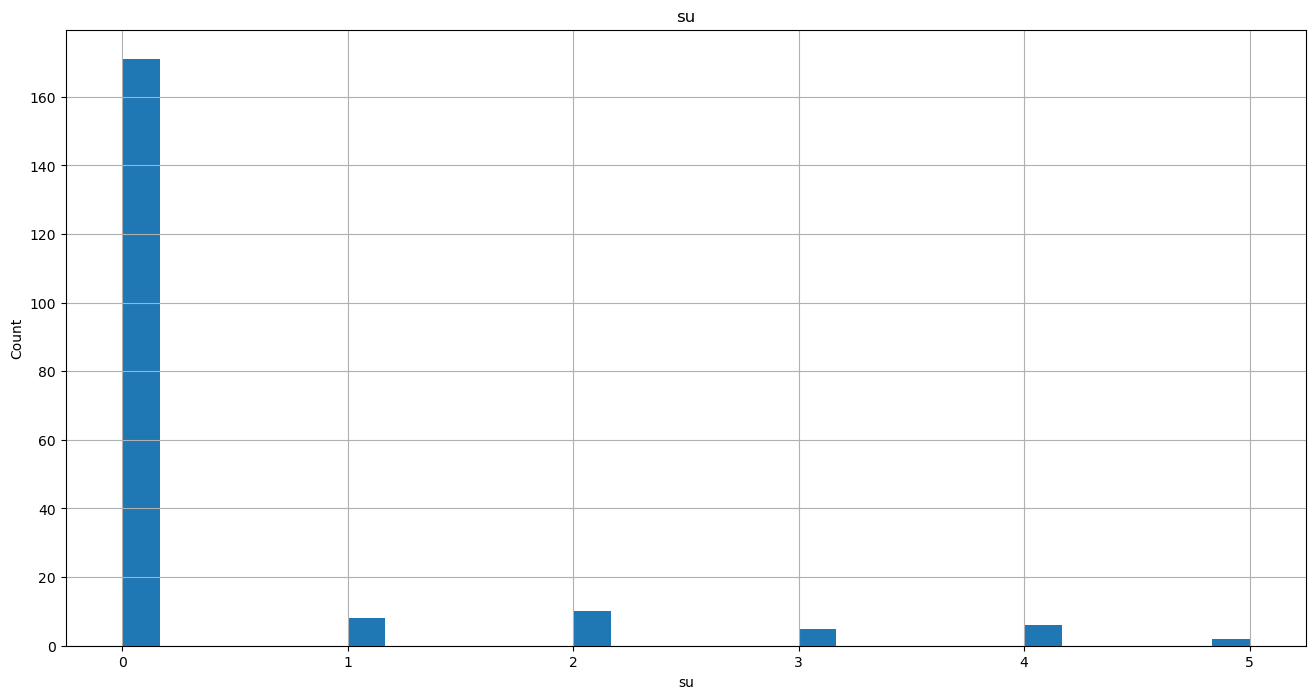

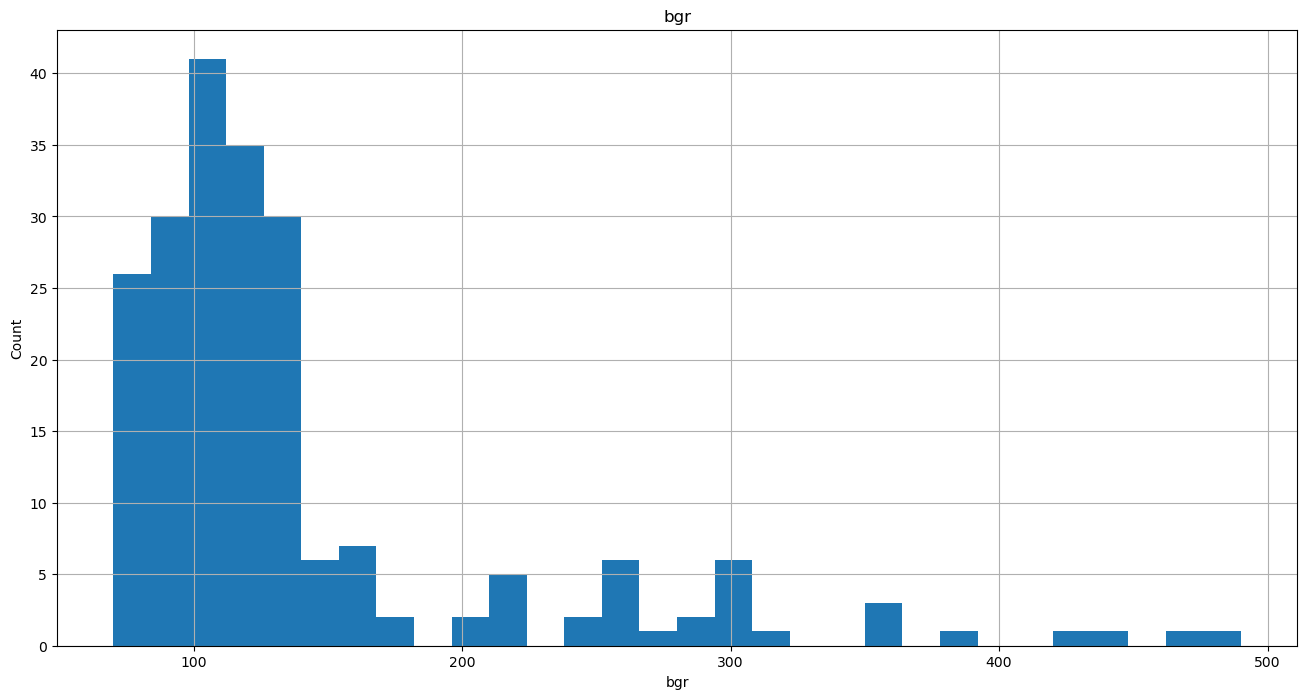

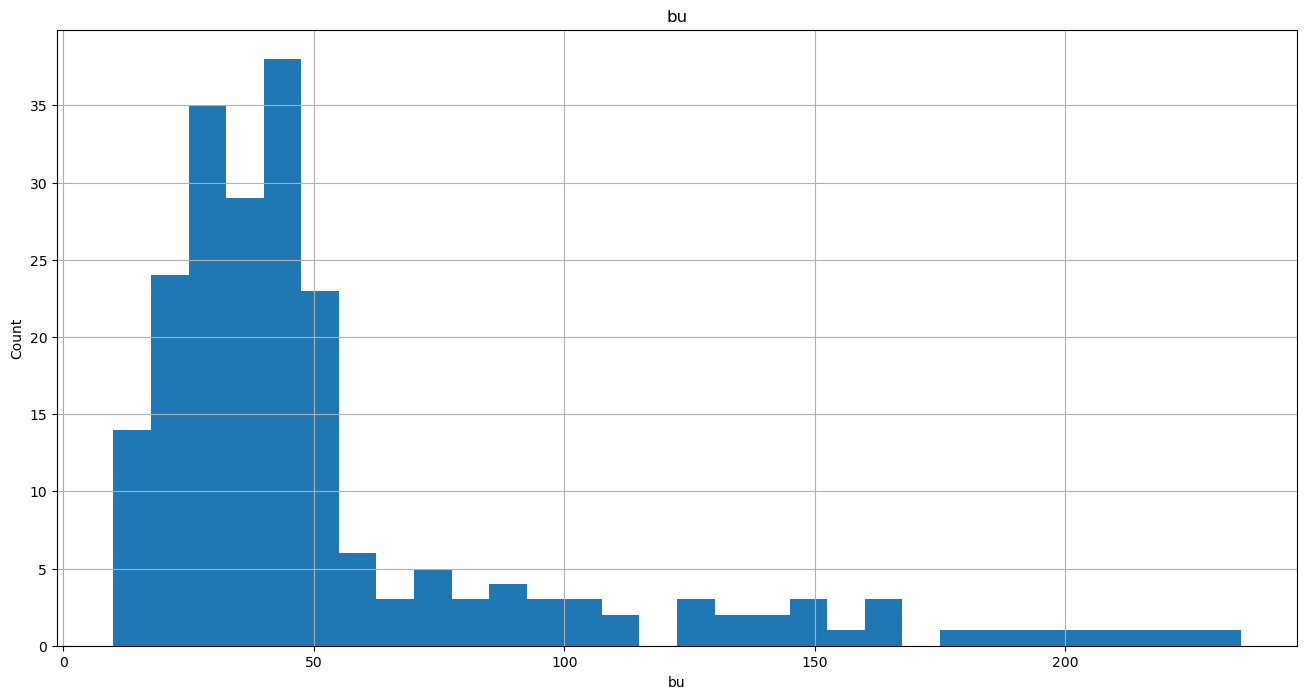

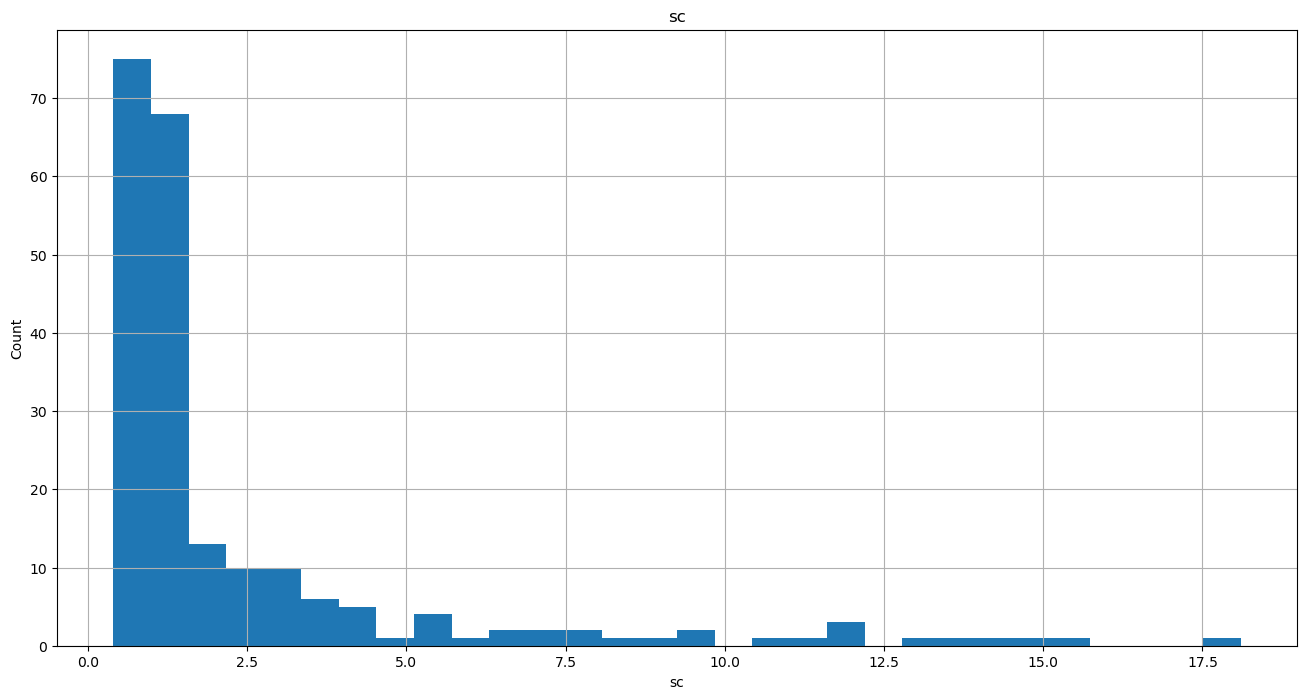

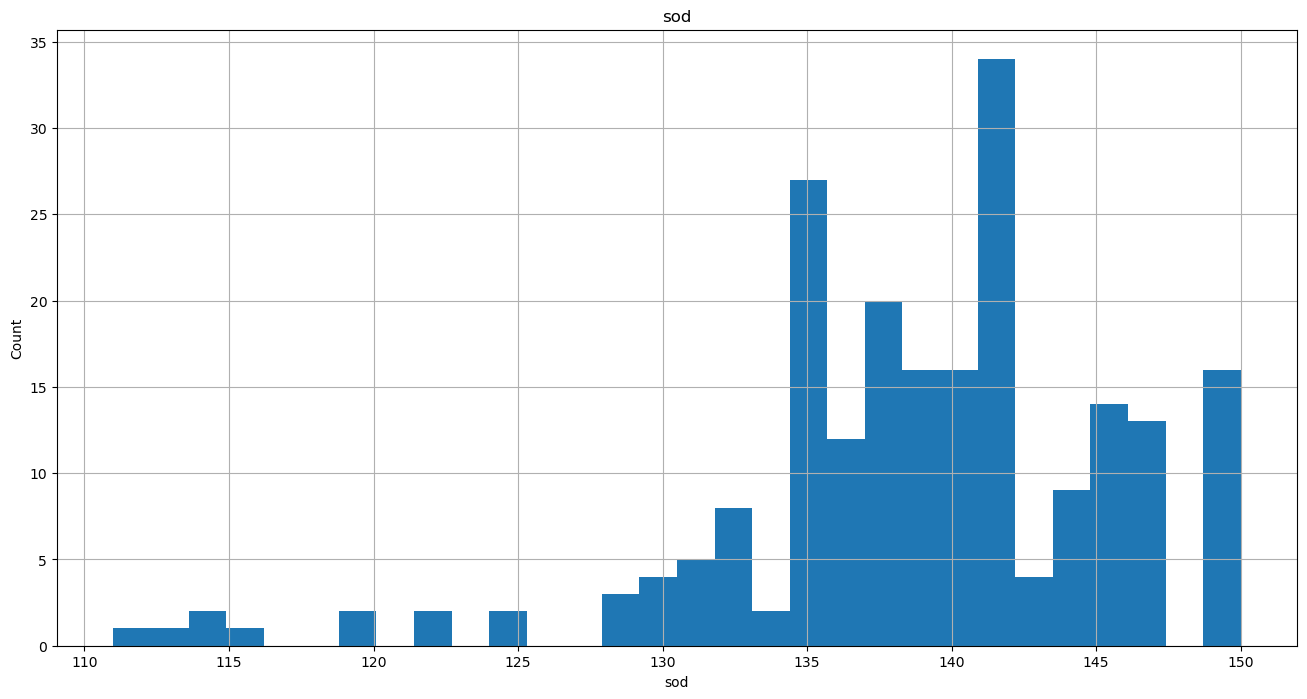

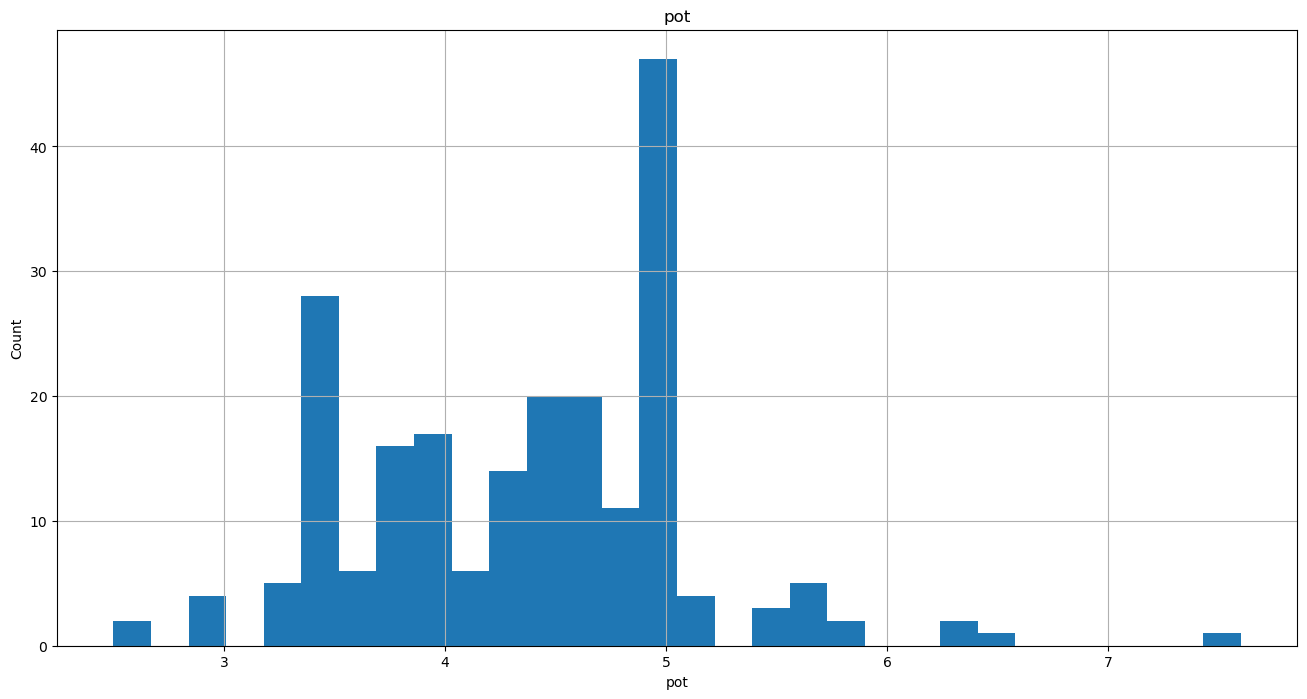

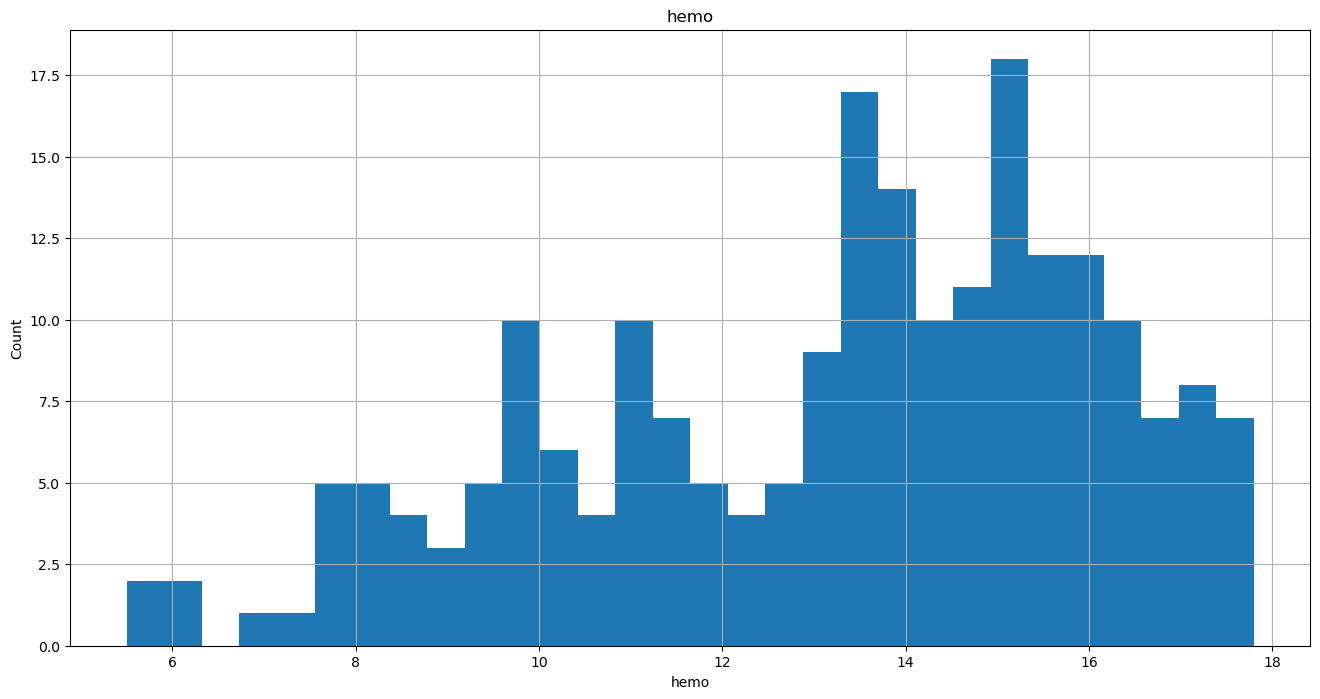

In [27]:
for num in data_num: 
    plt.figure(figsize = (16, 8))
    data[num].hist(bins=30)
    plt.ylabel('Count')
    plt.xlabel(num)
    plt.title(num)
    plt.show()

проверим наличие пропусков

In [28]:
all_feat = data_cats + data_num # соберем все признаки в один список
all_feat.remove('classification') # удалим таргет

for feat in all_feat:
    nan_value = data[feat].isnull().sum()
    print(f'признак - {feat}, количество пропусков - {nan_value}')

признак - rbc, количество пропусков - 47
признак - pc, количество пропусков - 21
признак - pcc, количество пропусков - 3
признак - ba, количество пропусков - 3
признак - pcv, количество пропусков - 0
признак - wc, количество пропусков - 0
признак - rc, количество пропусков - 0
признак - htn, количество пропусков - 2
признак - dm, количество пропусков - 2
признак - cad, количество пропусков - 2
признак - appet, количество пропусков - 1
признак - pe, количество пропусков - 1
признак - ane, количество пропусков - 1
признак - age, количество пропусков - 0
признак - bp, количество пропусков - 3
признак - sg, количество пропусков - 13
признак - al, количество пропусков - 12
признак - su, количество пропусков - 12
признак - bgr, количество пропусков - 4
признак - bu, количество пропусков - 0
признак - sc, количество пропусков - 0
признак - sod, количество пропусков - 0
признак - pot, количество пропусков - 0
признак - hemo, количество пропусков - 0


замени пропуски в категориальных признаках на моду

In [29]:
list_gap_bin = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']

for gap in list_gap_bin:
    data[gap] = data[gap].fillna(data[gap].mode())

заменим пропуски в непрерывнх признаках на среднее

In [30]:
list_gap_con = ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']

for gap in list_gap_con:
    data[gap] = data[gap]. fillna(data[gap].mean())

In [31]:
data.head(3)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
5,60.0,90.0,1.015,3.0,0.0,NaN,NaN,notpresent,notpresent,74.0,...,39.0,7800.0,4.4,yes,yes,no,good,yes,no,ckd
9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,70.0,...,29.0,12100.0,3.7,yes,yes,no,poor,no,yes,ckd


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 3 to 399
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             214 non-null    float64
 1   bp              214 non-null    float64
 2   sg              214 non-null    float64
 3   al              214 non-null    float64
 4   su              214 non-null    float64
 5   rbc             167 non-null    object 
 6   pc              193 non-null    object 
 7   pcc             211 non-null    object 
 8   ba              211 non-null    object 
 9   bgr             214 non-null    float64
 10  bu              214 non-null    float64
 11  sc              214 non-null    float64
 12  sod             214 non-null    float64
 13  pot             214 non-null    float64
 14  hemo            214 non-null    float64
 15  pcv             214 non-null    float64
 16  wc              214 non-null    float64
 17  rc              214 non-null    flo

Вывод:
датасет содержит

- категориальные признаки - 'rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'pe', 'ane', 'appet'

- непрерывные признаки - 'age', 'bp', 'sg', 'al', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'su', 'pcv', 'wc', 'rc'

# Feature engineering

переводим target в бинарный вид

In [33]:
data['classification'] = data['classification'].apply(lambda x: 1 if x == 'ckd' or x == 'ckd\t' else 0)

перевод категориальных признаков в бинарные

In [34]:
list_feats_to_bin = ['rbc', 'pc','pcc', 'ba', 'htn', 'dm', 'cad', 'pe', 'ane', 'appet'] 

def feats_to_bin(feats_to_bin):
    data[feats_to_bin] = data[feats_to_bin].apply(lambda x: 1 if (x == 'normal') or (x == 'present') or (x == 'yes') or (x == 'good') else 0)


for feat in list_feats_to_bin:
    feats_to_bin(feat)

соотношение классов целевой переменной 

In [35]:
data.iloc[:, -1].value_counts()

0    128
1     86
Name: classification, dtype: int64

Вывод: соотношение классов целевой переменной - условно сбалансированно

In [36]:
data.head(3)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
3,48.0,70.0,1.005,4.0,0.0,1,0,1,0,117.0,...,32.0,6700.0,3.9,1,0,0,0,1,1,1
5,60.0,90.0,1.015,3.0,0.0,0,0,0,0,74.0,...,39.0,7800.0,4.4,1,1,0,1,1,0,1
9,53.0,90.0,1.020,2.0,0.0,0,0,1,0,70.0,...,29.0,12100.0,3.7,1,1,0,0,0,1,1


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 3 to 399
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             214 non-null    float64
 1   bp              214 non-null    float64
 2   sg              214 non-null    float64
 3   al              214 non-null    float64
 4   su              214 non-null    float64
 5   rbc             214 non-null    int64  
 6   pc              214 non-null    int64  
 7   pcc             214 non-null    int64  
 8   ba              214 non-null    int64  
 9   bgr             214 non-null    float64
 10  bu              214 non-null    float64
 11  sc              214 non-null    float64
 12  sod             214 non-null    float64
 13  pot             214 non-null    float64
 14  hemo            214 non-null    float64
 15  pcv             214 non-null    float64
 16  wc              214 non-null    float64
 17  rc              214 non-null    flo

переопределим индексы

In [38]:
data = data.reset_index(drop=True)

In [39]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self
        

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]
    

    
continuos_cols = ['age', 'bp',   'bgr', 'bu',  'sod', 'pot', 'su', 'pcv', 'wc', 'rc'] # непрерывные признаки
cat_cols = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'pe', 'ane', 'appet'] # категориальные признаки 
base_cols = ['hemo', 'sc', 'al', 'sg'] # основные признаки 

continuos_transformers = []
cat_transformers = []
base_transformers = []

  
for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

In [40]:
# ohe = pd.get_dummies(data=data, columns=cat_cols)
# print(ohe.info())

ohe_cols = ['rbc_0', 'rbc_1', 'pc_0', 'pc_1', 'pcc_0', 'pcc_1',  'ba_0', 'ba_1', 'htn_0',
            'htn_1', 'dm_0', 'dm_1', 'cad_0', 'cad_1', 'pe_0', 'pe_1', 'ane_0', 'ane_1', 'appet_0', 'appet_1']      

total_cols = continuos_cols + ohe_cols + base_cols

разобьем выборку на тренировочную и тестовую части

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.drop('classification', 1), data['classification'], random_state=0)

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             214 non-null    float64
 1   bp              214 non-null    float64
 2   sg              214 non-null    float64
 3   al              214 non-null    float64
 4   su              214 non-null    float64
 5   rbc             214 non-null    int64  
 6   pc              214 non-null    int64  
 7   pcc             214 non-null    int64  
 8   ba              214 non-null    int64  
 9   bgr             214 non-null    float64
 10  bu              214 non-null    float64
 11  sc              214 non-null    float64
 12  sod             214 non-null    float64
 13  pot             214 non-null    float64
 14  hemo            214 non-null    float64
 15  pcv             214 non-null    float64
 16  wc              214 non-null    float64
 17  rc              214 non-null    flo

# Модель xgboost

In [43]:
import xgboost as xgb

model = Pipeline([
    ('features', feats),
    ('classifier', xgb.XGBRegressor()),
])

#обучим наш пайплайн
model.fit(X_train, y_train)

y_predict = model.predict(X_test)

In [44]:
from sklearn.metrics import mean_absolute_error, r2_score


predictions =  model.predict(X_test)
 
mean_absolute_error(y_pred=predictions, y_true=y_test), r2_score(y_pred=predictions, y_true=y_test)

(0.026905582313432846, 0.9227974325056714)

важность признаков

In [45]:
xgb_features = pd.DataFrame(model[1].feature_importances_, 
                            total_cols,
                        columns=['coefficient']
                           )
xgb_features.head()

,coefficient
age,0.000013
bp,0.000003
bgr,0.000005
bu,0.000026
sod,0.000002


# SHAP

весь тестовый набор данных

In [46]:
model = xgboost.train({"learning_rate": 0.01}, 
                      xgboost.DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.initjs()

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

Вывод: наибольший вклад в снижение риска развития заболевания почек (снижения score) вносят признаки sc, hemo, отсутствие dm

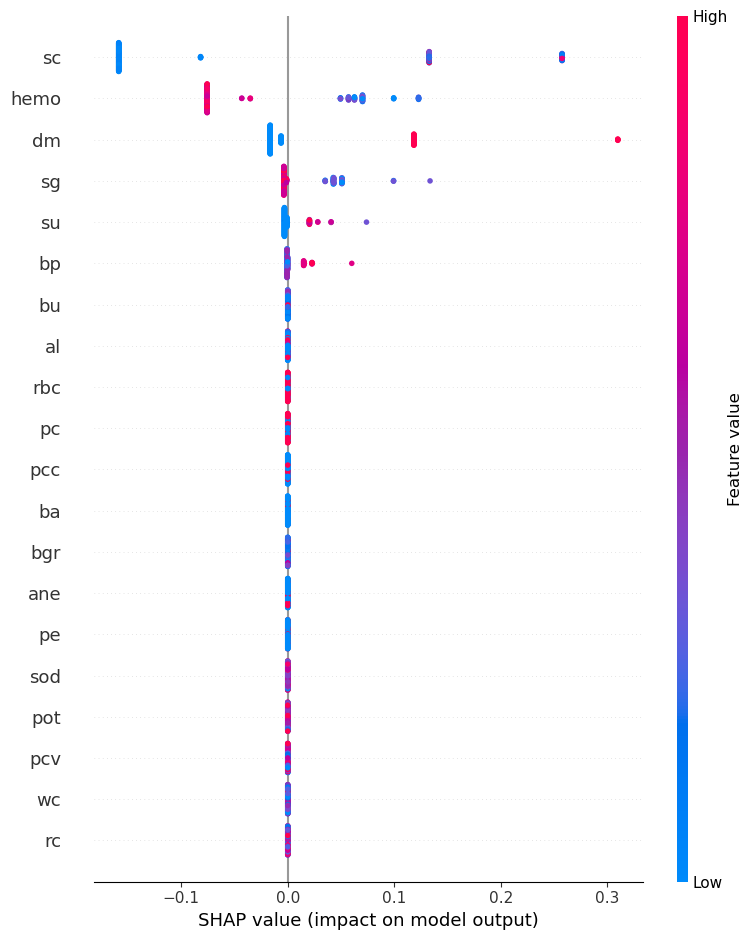

In [47]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

Вывод: Вклад в увеличение score (увеличение риска разивтия заболеваний почек) вносят:

- снижение hemo
- снижение sg
- увеличение su
- увеличение bp
- наличие dm

sc? 

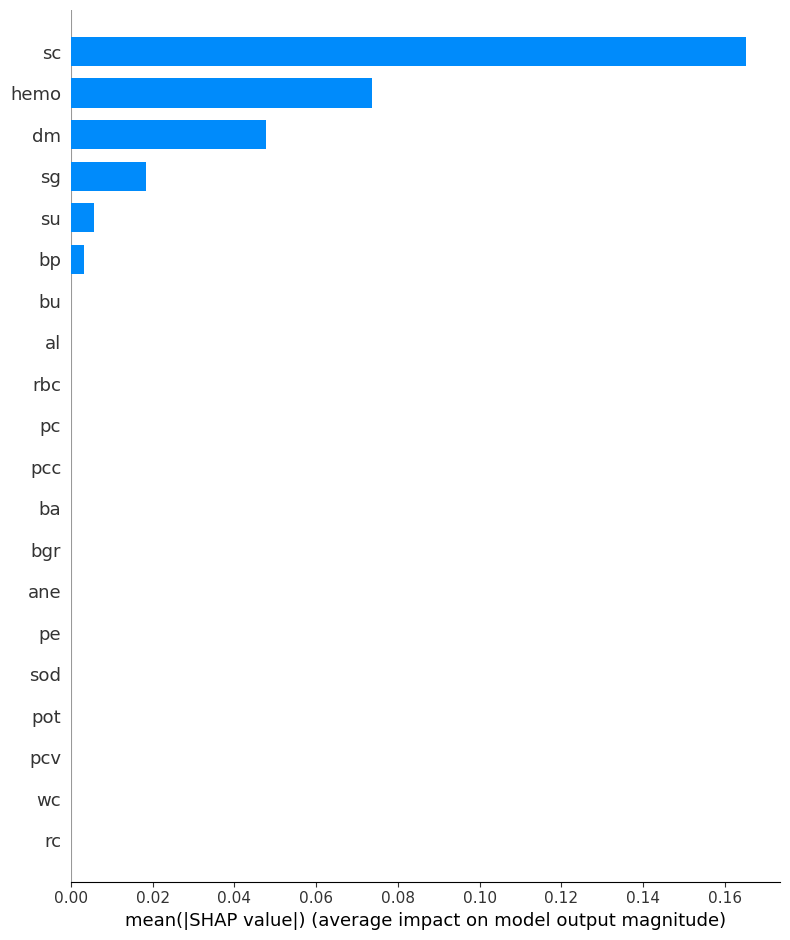

In [48]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

Вывод: Набиольший вклад в увеличении рска развития заболеваний почек играют (по убыванию): sc, hemo, dm, sg, su, bp

## force_plot и интерпретация отдельных результатов

In [49]:
nm_val = 1

shap.force_plot(explainer.expected_value, shap_values[nm_val], X_train.iloc[nm_val])

Вывод: score равен 0.81 , наибольшее значение в увеличении score внесли высокое значение sc, низкое - hemo, низкое sg

--------

In [50]:
nm_val = 12

shap.force_plot(explainer.expected_value, shap_values[nm_val], X_train.iloc[nm_val])

Вывод: score равен 0,18, наибольшее значение в снижение score (снижении риска развития заболевания почек) внесли высокий hemo, низкий sc, отсутствие dm

------

In [51]:
nm_val = 37

shap.force_plot(explainer.expected_value, shap_values[nm_val], X_train.iloc[nm_val])

Вывод: score равен 0,79, наибольшее значение в уменьшение score внесло значение sc, в увеличении - hemo, sg, наличие dm